In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

## Задаем параметры из литературы

In [26]:
death_shift_days = -21 # нужно будет поменять на 21
cases_shift_days = -10
lethality = 0.0066
rolling_window_for_coeff = 5
tau_e=5.1
tau_i=2.83

## Функции для ключевых параметров

#### Темп удвоения числа заболевших в расчете на каждую дату.

```
Вычисляется как: lg(2)/lg(1 + число из колонки I на данную дату)
```

In [27]:
def get_Td(x):
    return np.log(2)/(np.log(1+x))

#### Rₒ
```
Rₒ= (1 + (𝜏ₑ/𝜏₂)ln2) (1 + (𝜏ᵢ/𝜏₂)ln2)
```

In [28]:
def get_R_naught(Td, tau_e=5.1, tau_i=2.83): # KWARGS
    a = 1 + (tau_e/Td)*np.log(2)
    b = 1 + (tau_i/Td)*np.log(2)
    R_naught = a*b
    return R_naught                                          

## Читаем данные из файла

В этой версии используется локальная копия. Это может быть изменено в будущем. 

In [29]:
df = pd.read_csv('real_data.csv', index_col=0, header=0, parse_dates=False)
df.index = pd.to_datetime(df.index, dayfirst=True)

## Делаем сдвиги рядов данных

In [30]:
df['death_shifted'] = df['death'].shift(death_shift_days)
df['cases_shifted'] = df['cases'].shift(cases_shift_days)
df['cases_expected'] = df['death_shifted']\
                            .rolling(rolling_window_for_coeff, center=True).mean()\
                            *(1/lethality)
df['coeff_cases'] = df['cases_shifted'].rolling(rolling_window_for_coeff, center=True).mean()\
                        /df['cases_expected']
# сдвигаем обратно коэффициент выявляемости
df['coeff_cases_forwardshifted'] = df['coeff_cases'].shift(-cases_shift_days)

## Моделируем коэффициент выявляемости


### Фиттинг расчитанных коэффициентов логистической кривой


Фиттинг в этом варианте чувствителен к параметрам death_shift_days и cases_shift_days, нужно обращать на них внимание 

Функция которая берет DataSeries коэффициента, фиттит его на логистическую функцию с максимумом 1 и возвращает DataSeries где пропущенные значения заменены смоделированными значениями.

In [31]:
def fit_and_input_coeffs(df,first_date_to_fit=None,last_date_to_fit=None):
    column_name = df.name
    index_name = df.index.name
    
    if not first_date_to_fit:
        first_date_to_fit = df.index[0]
    if not last_date_to_fit:
        last_date_to_fit  = df.index[-1]
    
    xdata = df[first_date_to_fit:last_date_to_fit].reset_index()[column_name].dropna().index.values
    ydata = df[first_date_to_fit:last_date_to_fit].reset_index()[column_name].dropna().values

    # fitting to log
    from scipy.optimize import curve_fit
    # Generalised logistic function
    # https://en.wikipedia.org/wiki/Generalised_logistic_function
    # implementation details https://stats.stackexchange.com/questions/190107/curve-fit-with-logarithmic-regression-in-python
    def gen_log_func(x, b, c, a,  d=1, g=0.5):
        return ( ( (a-d) / ( (1+( (x/c)**b )) **g) ) + d )
    # fit the data
    popt, pcov = curve_fit(gen_log_func, xdata, ydata, p0=(1,1,0))
    # curve params
    p1 = popt[0]
    p2 = popt[1]
    p3 = popt[2]


    df = df.reset_index()
    # find and input missing values
    f = df[column_name].isna()
    for i in df[f].index:
        df.loc[i,column_name]= gen_log_func(df.index[i],p1,p2,p3)
    
    # return Series in original format
    return df.set_index(index_name, drop=True)[column_name]

Функция которая возвращает серию самой функции после фиттинга

In [32]:
def get_fitting_curve(df,first_date_to_fit=None,last_date_to_fit=None):
    column_name = df.name
    index_name = df.index.name
    
    if not first_date_to_fit:
        first_date_to_fit = df.index[0]
    if not last_date_to_fit:
        last_date_to_fit  = df.index[-1]
    
    xdata = df[first_date_to_fit:last_date_to_fit].reset_index()[column_name].dropna().index.values
    ydata = df[first_date_to_fit:last_date_to_fit].reset_index()[column_name].dropna().values

    # fitting to log
    from scipy.optimize import curve_fit
    # Generalised logistic function
    # https://en.wikipedia.org/wiki/Generalised_logistic_function
    # implementation https://stats.stackexchange.com/questions/190107/curve-fit-with-logarithmic-regression-in-python
    def gen_log_func(x, b, c, a,  d=1, g=0.5):
        return ( ( (a-d) / ( (1+( (x/c)**b )) **g) ) + d )
    # fit the data
    popt, pcov = curve_fit(gen_log_func, xdata, ydata, p0=(1,1,0))
    # curve params
    p1 = popt[0]
    p2 = popt[1]
    p3 = popt[2]
    
    df = df.reset_index()
    # find and input missing values
#     f = df[column_name].isna()
    for i in df.index:
        df.loc[i,column_name]= gen_log_func(df.index[i],p1,p2,p3)
    
    # return Series in original format
    return df.set_index(index_name, drop=True)[column_name]

## Первый сценарий - коэффициент остается средним

In [33]:
# df['coeff_cases_model'] = df['coeff_cases_forwardshifted']

# B = df['coeff_cases_model'].dropna().index[-1]
# mean_forward_coeff_cases = df['coeff_cases_model'].dropna()[-rolling_window_for_coeff:].mean()

# for date in df[B:]['coeff_cases_model'][1:].index:
#     df.loc[date, 'coeff_cases_model'] = mean_forward_coeff_cases

## Второй сценарий - коэффициент растет в соответствии с кривой

In [34]:
## Добавляем коэффициенты в конец и начало

df['coeff_cases_model'] = fit_and_input_coeffs(df['coeff_cases_forwardshifted'])
df['coeff_cases_curve'] = get_fitting_curve(df['coeff_cases_forwardshifted'])

### Считаем время удвоения и Rₒ

df['cases_adj'] = df['cases']/df['coeff_cases_model']

df['cases_adj_rate'] = df['cases_adj']/(df['cases_adj'].cumsum())

df['doubling_time'] = df['cases_adj_rate'].apply(get_Td)

df['doubling_time_rolling'] = df['doubling_time'].rolling(rolling_window_for_coeff, center=True).mean()

df['R_naught']=df['doubling_time_rolling'].apply(get_R_naught)

### Последний вычисленный Rₒ для модели SEIR

df['R_naught'].dropna().tail(1)

time
2020-04-26    1.458538
Name: R_naught, dtype: float64

### Считаем время удвоения и Rₒ

In [35]:
df['cases_adj'] = df['cases']/df['coeff_cases_model']

df['cases_adj_rate'] = df['cases_adj']/(df['cases_adj'].cumsum())

df['doubling_time'] = df['cases_adj_rate'].apply(get_Td)

df['doubling_time_rolling'] = df['doubling_time'].rolling(rolling_window_for_coeff, center=True).mean()

df['R_naught']=df['doubling_time_rolling'].apply(get_R_naught)

### Последний вычисленный Rₒ для модели SEIR

In [36]:
df['R_naught'].dropna().tail(1)

time
2020-04-26    1.458538
Name: R_naught, dtype: float64

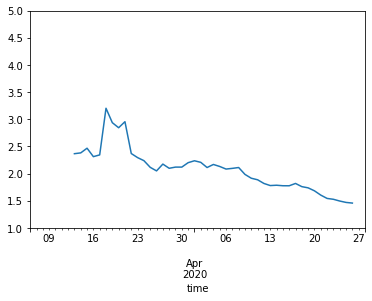

In [37]:
df['R_naught'].plot(ylim=(1,5))

## Экспорт данных

In [38]:
# df.to_excel('prognosis_scenary_2.xlsx')

Пример ссылки на моделирование:

```
https://covid19-scenarios.org/?v=1&q=~(current~'Custom~containment~(~(id~'ac250f95-ce49-4663-abff-2105ea02d3b9~name~'Intervention*201~color~'*2372640c~mitigationValue~35~timeRange~(tMin~1585040400000~tMax~1586854800000))~(id~'e1a5a1e8-bd24-42b8-8fdc-0fb4d1a569ed~name~'Intervention*20from*2015*20Apr*202020~color~'*2396c453~mitigationValue~80~timeRange~(tMin~1586914972915~tMax~1593507600000)))~population~(cases~'Russian*20Federation~country~'Russian*20Federation~hospitalBeds~100000~ICUBeds~40500~importsPerDay~0.1~initialNumberOfCases~750~populationServed~146745098)~epidemiological~(infectiousPeriod~2.82~latencyTime~5.1~lengthHospitalStay~7~lengthICUStay~7~overflowSeverity~2~peakMonth~0~r0~3.8~seasonalForcing~0.2)~simulation~(simulationTimeRange~(tMin~1584090000000~tMax~1593507600000)~numberStochasticRuns~0)~ageDistribution~(0-9~18622607~10-19~15256035~20-29~15607785~30-39~24468554~40-49~20375320~50-59~18897667~60-69~18501370~70-79~8549716~80*2b~5655408))
```